# Проектная работа: "Банки — Анализ оттока клиентов"

Ссылка на презентацию: https://disk.yandex.ru/i/chIXxh4wf66iIQ

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City — город,
- Gender — пол,
- Age — возраст,
- Objects — количество объектов в собственности,
- Balance — баланс на счёте,
- Products — количество продуктов, которыми пользуется клиент,
- CreditCard — есть ли кредитная карта,
- Loyalty — активный клиент,
- estimated_salary — заработная плата клиента,
- Churn — ушёл или нет.

## Шаг. Загрузим данные

In [1]:
# импортируем бибилиотеки
import pandas as pd
import seaborn as sns
from datetime import date

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,recall_score,precision_score

from scipy.cluster.hierarchy import dendrogram, linkage 
import numpy as np
from IPython.display import display

from scipy import stats as st
import numpy as np
import math as mth
import plotly.express as px

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats import weightstats as stests
import warnings
warnings.filterwarnings('ignore')

In [2]:
# чтение файла с данными и сохранение его в переменную
bank_data = pd.read_csv('/datasets/bank_dataset.csv', sep=',')

In [3]:
# посмотрим общую информацию о данных
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
# посмотрим на 10 первых значений
bank_data.head(10)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


**Вывод**

В датасете 12 колонок с записями о клиентах и действиях. Всего 10000 строк в каждом столбце, кроме 'Balance'(необходимо заполнить пропущенные значения). Название столбцов в датасете нужно привести к нижнему регистру. Все типы данных корректны.

## Шаг. Проведем предобработку данных

In [5]:
# приведем названия столбцов датаcета к нижнему регистру
bank_data.columns = map(str.lower, bank_data.columns)

In [6]:
# проверим на дубликаты
bank_data.duplicated().sum()

0

In [7]:
# проверим колонки на пропущенные значения
bank_data.isna().mean()

userid              0.0000
score               0.0000
city                0.0000
gender              0.0000
age                 0.0000
objects             0.0000
balance             0.3617
products            0.0000
creditcard          0.0000
loyalty             0.0000
estimated_salary    0.0000
churn               0.0000
dtype: float64

Отсутствуют 3617 значений в столбце 'balance'. Баланс может быть нулевым, так как не все продукты предполагают наличие дебетового счета. Если он отсутствует, можно считать его нулевым и заполнить нулями. Но прежде посмотрим, если особенности в пропущенных значениях 'balance' у активных и ушедших клиентов.

In [8]:
# cформируем таблицы активных и ушедших клиентов, где есть пропущенные значения
churn_bank_data = bank_data[bank_data['churn'] == 1]
active_bank_data = bank_data[bank_data['churn'] == 0]

In [9]:
print('Статистика балансов у ушедших клиентов:')
print('Cреднее значение:', churn_bank_data['balance'].mean())
print('Медиана:', churn_bank_data['balance'].median())

Статистика балансов у ушедших клиентов:
Cреднее значение: 120746.97113207547
Медиана: 119948.09


In [10]:
print('Статистика балансов у активных клиентов:')
print('Среднее значение:', active_bank_data['balance'].mean())
print('Медиана:', active_bank_data['balance'].median())

Статистика балансов у активных клиентов:
Среднее значение: 119535.86426950061
Медиана: 119791.215


In [11]:
print('Общая статистика:')
print('Среднее значение:', bank_data['balance'].mean())
print('Медиана:', bank_data['balance'].median())

Общая статистика:
Среднее значение: 119827.49379288737
Медиана: 119839.69


In [12]:
print('Пропущенные значения у ушедших клиентов:', churn_bank_data['balance'].isna().mean())
print('Пропущенные значения у активных клиентов:', active_bank_data['balance'].isna().mean())

Пропущенные значения у ушедших клиентов: 0.24545900834560627
Пропущенные значения у активных клиентов: 0.39143538867261085


Особенностей в пропущенных значениях баланса у активных и ушедших клиентов не обнаружено. Пропущенные значения 'balance' оставим без изменений, т.к. замена на нули и другие значения может привести к изменению средних значений по балансу и сместить распределение влево.

In [13]:
#заменим отсутствующий баланс на нули
#bank_data['balance'] = bank_data['balance'].fillna(0)

**Вывод**

В ходе предобработки подготовили данные для дальнейшего исследовательского анализа. Колонки и данные предоработаны.
Дубликатов не обнаружено. Не выявлено особенностей в пропущенных значениях 'balance' у активных и ушедших клиентов. Пропущенные значения в столбце 'balance' заменены на нули.

## Шаг. Проведем исследовательский анализ данных (EDA)

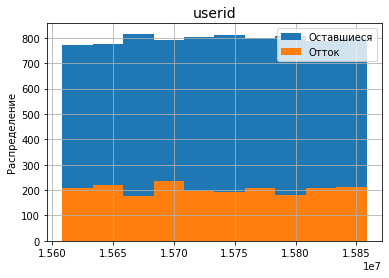

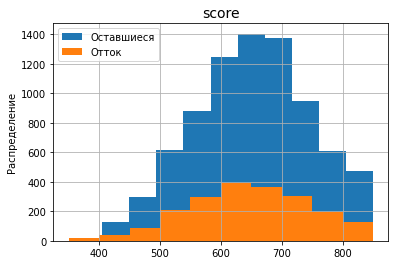

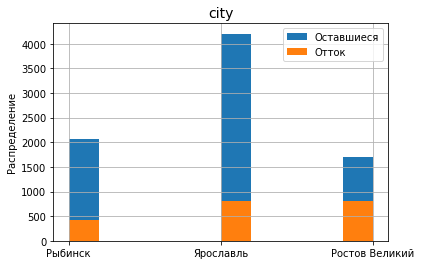

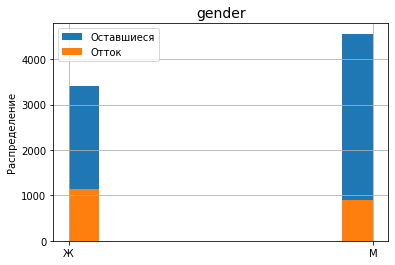

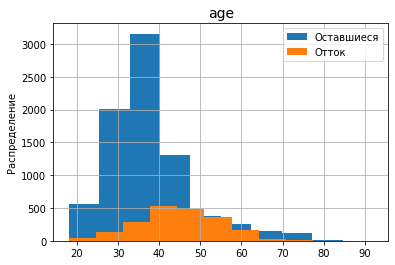

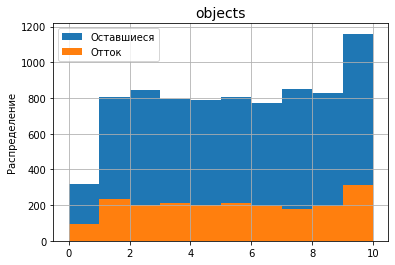

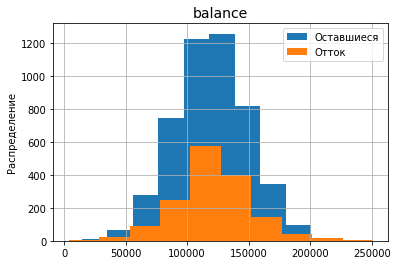

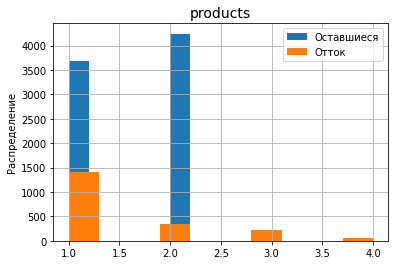

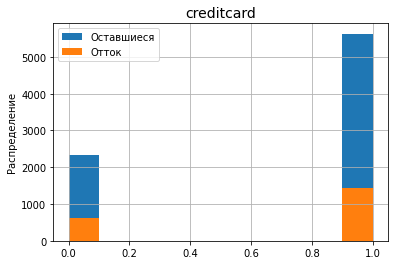

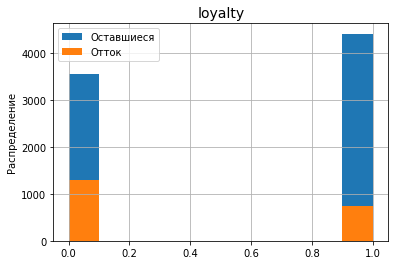

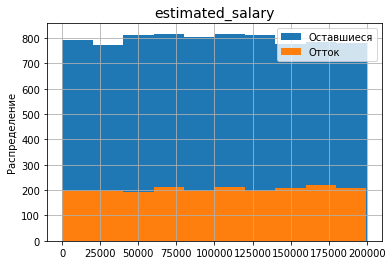

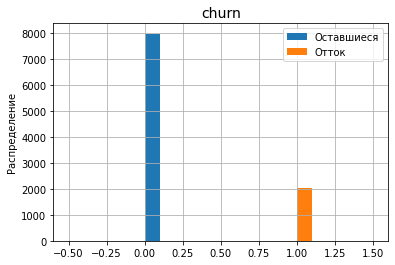

In [14]:
# построим гистограммы распределения каждой величины в разбивке по churn
bank_data_churn_0 = bank_data[bank_data['churn'] == 0] # осталися
bank_data_churn_1 = bank_data[bank_data['churn'] == 1] # ушли

for column in bank_data.columns:
    'Функция строит гистограмму распределения колонки column из датафрейма bank_data'
    bank_data.groupby('churn')[column].hist()
    plt.title(column, fontsize=14)
    plt.ylabel('Распределение')
    plt.legend(['Оставшиеся', 'Отток'])
    plt.show()

По построенным гистограммам можно сделать промежуточный вывод:
    - распределение по баллам кредитного скоринга примерно равное как для тех кто ушел, так и для тех, кто остался;
    - в Рыбинске клиенты уходят в два раза меньше чем, в Ярославле и Ростове;
    - женщин уходит больше чем мужчин;
    - клиенты старше 45 лет больше склонны к оттоку;
    - доход по счёту, баланс и количество объектов не влияет на отток;
    - оптимальное количество продуктов - 2 и 3,4 - продукта только у клиентов которые ушли;
    - кредитные карты скорее влияют на отток, чем нет;
    - низкая лояльность у клиентов которые ушли;
    - равномерная заработная плата у всех клиентов независимо.

In [15]:
# изучим средние значения и стандартные отклонения методом describe()
bank_data.describe().round(2)

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,10000.00,10000.00,10000.00,10000.00,6383.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,15733676.57,650.53,38.92,5.01,119827.49,1.53,0.71,0.52,100090.24,0.2
std,71936.19,96.65,10.49,2.89,30095.06,0.58,0.46,0.50,57510.49,0.4
min,15608437.00,350.00,18.00,0.00,3768.69,1.00,0.00,0.00,11.58,0.0
25%,15671264.25,584.00,32.00,3.00,100181.98,1.00,0.00,0.00,51002.11,0.0
50%,15733474.00,652.00,37.00,5.00,119839.69,1.00,1.00,1.00,100193.92,0.0
75%,15795969.75,718.00,44.00,7.00,139512.29,2.00,1.00,1.00,149388.25,0.0
max,15858426.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


По построенной таблице можно сделать промежуточный вывод:

- максимальный балл кредитного скоринга составляет 850 единиц, минимальный - 350. Медиана и среднее примерно равны - 652 и 650 соответственно, так что можем предположить, что данные распределены нормально;
- максимальное число объектов у клиентов в собственности - 10, минимальное - 0. Среднее и медиана - 5 объектов. Коэффициент вариации равен 58%, поэтому можно сказать, что выборка сильно вариабельна;
- количество продуктов, которыми пользуется клиент, составляет в среднем 1. Медиана равна 1, среднее - 1,5. Минимальное число продуктов - 1, максимальное - 4 продукта;
- у 71% клиентов есть кредитная карта банка;
- ~ 52% клиентов из выборки являются активными клиентами банка;
- предполагаемая средняя заработная плата клиента составляет 100 тысяч рублей, медиана примерно на том же уровне (100193), распределение нормальное. Максимальная зарплата - 199992 рублей, минимальная - 11,58 рублей (возможно, ошибка заполнения данных клиентом);
- почти 20% из клиентов - это те, кто ушли, 80% остались клиентами банка.


In [16]:
# присвоим полу бинарные значения и изменим тип данных
bank_data['gender'] = bank_data['gender'].replace('Ж','0').replace('М','1').astype('int')

In [17]:
# используем преобразование one-hot encoding
bank_data_hot = bank_data.copy()
bank_data_hot = pd.get_dummies(bank_data_hot, columns=['city'])
display(bank_data_hot.head())

,userid,score,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,15677338,619,0,42,2,NaN,1,1,1,101348.88,1,0,0,1
1,15690047,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15662040,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0,1
3,15744090,699,0,39,1,NaN,2,0,0,93826.63,0,0,0,1
4,15780624,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [18]:
# посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался методом groupby()
bank_data_hot.groupby('churn').mean().round(2).T

churn,0,1
userid,15733903.88,15732787.96
score,651.85,645.35
gender,0.57,0.44
age,37.41,44.84
objects,5.03,4.93
balance,119535.86,120746.97
products,1.54,1.48
creditcard,0.71,0.70
loyalty,0.55,0.36
estimated_salary,99738.39,101465.68


**Вывод**

Распределение по баллам кредитного скоринга для ушедших и оставшихся клиентов банка, в среднем - 645-652 баллов.
Средний возраст клиентов, попавших в отток выше (45 лет), чем возраст тех, кто остался (37 лет).
Среднее количество объектов в собственности у обоих групп - 5.
Среди тех, кто ушел, большинство - это женщины (55%), а среди тех, кто остался - это мужчины (57%).
Средний баланс на счёте оставшихся клиентов  - 119536 руб. Средний баланс на счёте ушедших клиентов  - 120747 руб.
Количество продуктов, которыми пользуются клиенты из оттока и не из оттока, примерно равно 1.5, будем считать, что это 1 продукт.
Распределение по наличию кредитной карты для ушедших и оставшихся клиентов банка, в среднем -70% 
Среди тех, кто попал в отток, только 36% были активными клиентами; а среди тех, кто остался, 55% - это активные клиенты.
Средняя заработная плата ушедших клиентов (101466) выше, чем средняя зартлата тех, кто остались клиентами банка (99738).
Большинство оставшихся клиентов из Ярославля (53%), далее идет Рыбинск (26%) и Ростов (21%), большинство ушедших клиентов из Ростова (40%) и Ярославля (40%), и только 20% из Рыбинска.

Портрет типичного ушедшего клиента: Женщина (возможно мужчина), старше 44 лет из Ростова Великого или Ярославля, с низкой активностью и балансом на счете выше среднего.

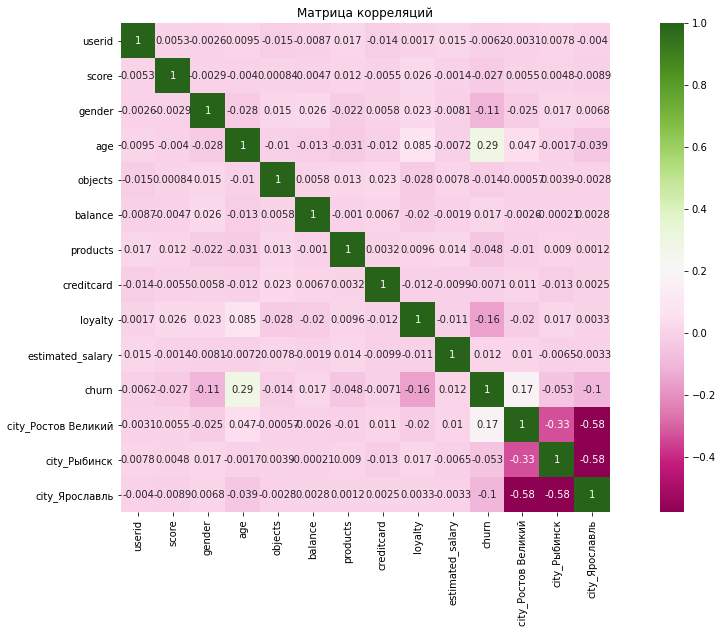

In [19]:
# проведем коррелякционный анализ путем построения корреляционной матрицы
corr = bank_data_hot.corr()

# нарисуем heatmap
plt.figure(figsize=(18, 9))
sns.heatmap(corr, annot = True, square = True, cmap="PiYG")
plt.title('Матрица корреляций')
plt.show()

**Вывод**

Замечаем, что отток наиболее сильно коррелирует с возрастом клиента (0,29), лояльностью (-0,16) и текущим балансом (0,12). Однако корреляция довольно слабая.

## Шаг. Формулировка и проверка статистических гипотез

_Проверим гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.
Гипотеза о равенстве средних двух генеральных совокупностей, следовательно_
    
**Нулевая гипотеза H₀:**
        
   - Средний доход между оставшимися и ушедшими клиентами равен
    
**Альтернативная гипотеза H₁:**
        
   - Средний доход между оставшимися и ушедшими клиентами отличается

Применим t-критерий Стьюдента, который используется для определения статистической значимости различий средних величин. Для применения t-критерия Стьюдента необходимо, чтобы исходные данные имели нормальное распределение. Также имеет значение равенство дисперсий (распределения) сравниваемых групп. При неравных дисперсиях применяется t-критерий в модификации Уэлча.

In [20]:
# сохраним в переменных bank_data_churn_0 и bank_data_churn_1 актуальные данные
bank_data_churn_0=bank_data.query("churn==0")
bank_data_churn_1=bank_data.query("churn==1")

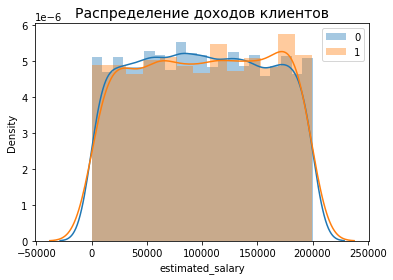

In [21]:
# проверим распределения
sns.distplot(bank_data_churn_0['estimated_salary'], label='0')
sns.distplot(bank_data_churn_1['estimated_salary'], label='1')
plt.title('Распределение доходов клиентов',fontsize=14)
plt.legend()
plt.show()

In [22]:
# рассчитаем дисперсию генеральных совокупностей 
print('Дисперсия ушедших:',bank_data_churn_0['estimated_salary'].var())
print('Дисперсия оставшихся:',bank_data_churn_1['estimated_salary'].var())

Дисперсия ушедших: 3295401414.9183965
Дисперсия оставшихся: 3353848166.8070116


Дисперсии отличаются менее чем на 5%.

Пороговое значение alpha примем за 5%.

In [23]:
alpha=0.05
results = st.ttest_ind(
    bank_data_churn_0['estimated_salary'], 
    bank_data_churn_1['estimated_salary'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.22644042802223352
Не получилось отвергнуть нулевую гипотезу


Не удалось отвергнуть нулевую гипотезу: 'Средний доход между оставшимися и ушедшими клиентами равен'.

_Проверим гипотезу различия оттока между теми клиентами, которые пользуются двумя и более продуктами банка, и теми, которые пользуются одним_
    
**Нулевая гипотеза H₀:**
        
   - Отток клиентов, которые пользуются двумя и более продуктами банка, и отток тех, которые пользуются одним, равны
    
**Альтернативная гипотеза H₁:**
        
   - Отток клиентов, которые пользуются двумя и более продуктами банка, и отток тех, которые пользуются одним, различаются

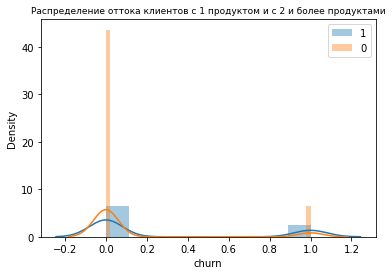

In [24]:
# проверим распределения
sns.distplot(bank_data.query('products == 1')['churn'], label='1')
sns.distplot(bank_data.query('products > 1')['churn'], label='0')
plt.title('Распределение оттока клиентов c 1 продуктом и с 2 и более продуктами', fontsize=9)
plt.legend()
plt.show()

На графиках видно, что отток у клиентов с 2 и более продуктами больше, чем у клиентов с 1 продуктом. 

Данные не похожи на нормальное распределение, т.к. всего 2 значения, поэтому нужен непараметрический критерий. Так как churn - величина бинарная, будет оптимальным использование Z-критерия для сравнения долей.

Пороговое значение alpha примем за 5%.

In [25]:
alpha = 0.05

results, pvalue = stests.ztest(
    bank_data.query('products == 1')['churn'], 
    x2=bank_data.query('products > 1')['churn'],
    value = 0,
    alternative='two-sided')

print('p-значение:', float(pvalue))

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.0079099625883425e-79
Отвергаем нулевую гипотезу


Удалось отвергнуть нулевую гипотезу: 'Отток клиентов, которые пользуются двумя и более продуктами банка, и отток тех, которые пользуются одним, равны'

**Вывод**

В ходе проверки гипотез выяснили, что средний доход между оставшимися и ушедшими клиентами не отличается и данный показатель не отражает отток клиентов. Однако, удалось выяснить, что на отток клиентов влияет количество используемых продуктов. Клиенты, которые пользуются одним продуктов не склонны уходить. 
    

## Шаг. Построим модель предсказания оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента.

In [26]:
# подготовим данные, удалим 2 столбца с названиями городов и полом
bank_data['balance'] = bank_data['balance'].fillna(0)
bank_data_ml= bank_data.drop(columns=['city', 'gender'])

In [27]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = bank_data_ml.drop(columns=['churn'], axis = 1)
y = bank_data_ml['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)
scaler=StandardScaler()
scaler.fit(X_train)
X_train_sc=scaler.transform(X_train)
X_test_sc=scaler.transform(X_test)

In [28]:
def train_model(n):
    'Функция обучает модель n на тестовых данных и рассчитывает все метрики'
    print(n)
    model=n
    model.fit(X_train_sc,y_train)
    y_pred=model.predict(X_test_sc)
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test,y_pred)), 
         '\nRecall: {:.3f}'.format(recall_score(y_test,y_pred)),
         '\nPrecision: {:.3f}'.format(precision_score(y_test,y_pred)),'\n')

In [29]:
for mod in [LogisticRegression(), RandomForestClassifier()]:
    train_model(mod)

LogisticRegression()
Accuracy: 0.807 
Recall: 0.167 
Precision: 0.591 

RandomForestClassifier()
Accuracy: 0.856 
Recall: 0.423 
Precision: 0.761 



**Вывод**

Обе модели показывают хорошую долю правильных ответов - 81% на логистичской регрессии и 86% случайным лесом. Доля правильных прогнозов и полнота чуть выше в модели случайного леса (~45% и ~74%), однако, недостаточно велика, для предсказания: что пользователь не уйдет, а он ушел. Из этого можно сделать вывод, что на этих данных можем обучить только слаботочные модели, для повышения точности нужно больше данных.


## Шаг. Вывод и рекомендации по проекту

Из анализа можно сделать вывод, что для клиентов банка «Метанпром» с наименьшим оттоком характерно: cредний возраст от 30 до 40 лет; проживают в Рыбинске; баланс на счете от 50 до 200 тыс. рублей; пользуется 1 продуктом; имеет кредитную карту; имеет несколько объектов в собственности;
активный клиент. 

Портрет клиента банка «Метанпром» с риском оттока характерно: средний возраст от 55 до 65 лет; проживает в Ростове Великом; неактивный; пользуется 3 или 4 продуктами; не имеет кредитной карты.

_На основе проведенного анализа рекомендуется:_

- предоставить дополнительные услуги/льготы для пользователей с 2 и более продуктами;
- провести анализ качества предоставляемых услуг в городе Ростов Великий;
- повышать активность клиентов: разработать программу cashback, предложить нестандартные условия по счетам и вкладам, привлечь новых клиентов за счет рекомендации друзей;
- предложить тематические продукты с привлекательными условиями для клиентов более старшего возраста.
